In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

jnp.array([0]) # So warnings don't show up later

DeviceArray([0], dtype=int64)

In [2]:
import sys
sys.path.append("../..")

from adversarial_ntks import attacks, jsvc

# Data generation

Our data in labeled by $Y \in \{0, 1\}$,
and $X | Y \sim \mathcal{N}(0, \sigma_Y \cdot I_d)$.

In [3]:
def generate_normal_data(dim, s0, s1, num_samples):
    assert num_samples % 2 == 0
    assert s0 <= s1
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    xs = np.concatenate([
        np.random.normal(scale=s0, size=(num_samples // 2, dim)),
        np.random.normal(scale=s1, size=(num_samples // 2, dim))
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def radial_attack(
    xs: np.ndarray, ys: np.ndarray,
    attack_norm, attack_eps,
):
    norm_xs = normalize(xs, norm=attack_norm)
    
    adv_xs = xs.copy()
    adv_xs[ys == 0] += attack_eps * norm_xs[ys == 0]
    adv_xs[ys == 1] -= attack_eps * norm_xs[ys == 1]
    
    return adv_xs

xs, ys = generate_normal_data(dim=2, s0=0.3, s1=0.7, num_samples=4)
radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1)

array([[ 0.16842881, -1.13761206],
       [ 0.77283049, -0.09478826],
       [-0.52217131,  1.32576964],
       [ 0.32815941,  0.34255325]])

## Some utilities

In [4]:
def accs_by_cls(preds, ys):
    return (preds[ys == 0] == 0).mean(), (preds[ys == 1] == 1).mean()

def fmt_accs(accs):
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

# Kernel SVM

#### Initial setup

In [5]:
RESULTS = dict() # used to store experiment artifacts

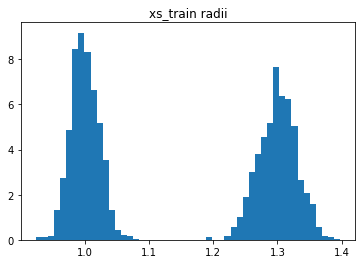

In [6]:
dim = 1000
s0, s1 = 1.0 / np.sqrt(dim), 1.3 / np.sqrt(dim)

xs_train, ys_train = generate_normal_data(
    dim=dim, s0=s0, s1=s1, num_samples=2000,
)
xs_test, ys_test = generate_normal_data(
    dim=dim, s0=s0, s1=s1, num_samples=1000,
)

plt.title("xs_train radii")
plt.hist(np.linalg.norm(xs_train, ord=2, axis=-1), density=True, bins=50);

### Poly, deg=2

### RBF

In [ ]:
%%time
attack_eps = 0.1

RESULTS["rbf"] = []
for c in [1e-3, 1e-2, 1e-1, 1]:
    clf = svm.SVC(kernel="rbf", C=c)
    clf.fit(xs_train, ys_train)
    
    accs_train = accs_by_cls(preds=clf.predict(xs_train), ys=ys_train)
    accs_test = accs_by_cls(preds=clf.predict(xs_test), ys=ys_test)    
    print(f"C={c}; accs_train={fmt_accs(accs_train)}; accs_test={fmt_accs(accs_test)}")
    
    xs_train_arad = radial_attack(xs=xs_train, ys=ys_train, attack_norm=2, attack_eps=attack_eps)
    xs_test_arad = radial_attack(xs=xs_test, ys=ys_test, attack_norm=2, attack_eps=attack_eps)
    accs_train_arad = accs_by_cls(preds=clf.predict(xs_train_arad), ys=ys_train)
    accs_test_arad = accs_by_cls(preds=clf.predict(xs_test_arad), ys=ys_test)
    print(f"C={c}; accs_train_arad={fmt_accs(accs_train_arad)}; accs_test_arad={fmt_accs(accs_test_arad)}")
    
    xs_train_pgd = attacks.pgd(
        X=jnp.array(xs_train), Y=jnp.array(ys_train),
        grad_func=lambda X: jsvc.grad_decision_function(clf, X),
        eps=attack_eps, eps_norm=2,
        step_size=attack_eps / 10, step_norm=2,
        num_steps=20
    )
    xs_test_pgd = attacks.pgd(
        X=jnp.array(xs_test), Y=jnp.array(ys_test),
        grad_func=lambda X: jsvc.grad_decision_function(clf, X),
        eps=attack_eps, eps_norm=2,
        step_size=attack_eps / 10, step_norm=2,
        num_steps=20
    )
    accs_train_pgd = accs_by_cls(preds=clf.predict(xs_train_pgd), ys=ys_train)
    accs_test_pgd = accs_by_cls(preds=clf.predict(xs_test_pgd), ys=ys_test)
    print(f"C={c}; accs_train_pgd={fmt_accs(accs_train_pgd)}; accs_test_pgd={fmt_accs(accs_test_pgd)}")

    
    RESULTS["rbf"].append(
        dict(
            clf=clf,
            accs_train=accs_train,
            accs_test=accs_test,
            attack_eps=attack_eps,
            accs_train_arad=accs_train_arad,
            accs_test_arad=accs_test_arad,
            accs_train_pgd=accs_train_pgd,
            accs_test_pgd=accs_test_pgd,
            xs_train_pgd=xs_train_pgd,
            xs_test_pgd=xs_test_pgd,
        )
    )

C=0.001; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=0.001; accs_train_arad=(0.9760, 0.9870); accs_test_arad=(0.9480, 0.9740)
